In [2]:
#| default_exp gkm_to_pwm

In [1]:
#| export
import numpy as np, pandas as pd
from Bio import SeqIO
import logomaker

from modules.gkm_to_kmers import *

In [5]:
exp = pd.read_csv('sp1_ml_datasets/ls-gkm/gkmexp_pos_impscores.txt', sep='\t', header=None, names=['seq_id', 'total_score', 'base_contrib'])
exp

,seq_id,total_score,base_contrib
0,chr20:257446-257646,-0.194996,"0,-0.000319389,0,0;0,0,-0.000640015,0;0,-0.001..."
1,chr20:290327-290527,0.452142,"0.00029,0,0,0;0.000121902,0,0,0;-2.98632e-05,0..."
2,chr20:297242-297442,0.238586,"1.85699e-05,0,0,0;-3.96274e-05,0,0,0;3.87967e-..."
3,chr20:310576-310776,0.647026,"0,-7.69097e-05,0,0;0,0,8.63976e-05,0;0,-0.0004..."
4,chr20:324472-324672,0.366285,"0,0,-0.000366061,0;0,0,-0.000560686,0;0,0,0,-0..."
...,...,...,...
195,chrX:3814879-3815079,0.023696,"0,0,1.80487e-05,0;1.78979e-05,0,0,0;0,-0.00027..."
196,chrX:3817555-3817755,0.221365,"2.78203e-05,0,0,0;0,0,0,-0.000220862;0,0,0.000..."
197,chrX:3817777-3817977,-0.222220,"0,0.000378686,0,0;0,0.000657848,0,0;0,0,0,0.00..."
198,chrX:3872336-3872536,0.268282,"8.64888e-05,0,0,0;0,0,0,-2.25235e-05;0,0,0,-0...."


In [2]:
seqs = fa_dict('sp1_ml_datasets/ls-gkm/test_pos_200bp.fa')

In [96]:
#| export
def aggregate_base_contribs_per_pos(exp, seqs, L):
    contribs, W, counts = np.zeros((L, 4)), np.zeros((L, 4)), np.zeros((L, 4))
    
    for i in range(len(exp)):
        raw_contrib = exp.loc[i,'base_contrib']
        seq = seqs[exp.loc[i,'seq_id']]

        for j,pos_vec in enumerate(raw_contrib.split(';')):
            contribs[j] = list(map(float, pos_vec.split(',')))

        for k,base in enumerate(seq):
            b = "ACGT".index(base)
            W[k, b] += contribs[k, b]
            counts[k, b] += 1
    return W, counts

In [97]:
W,counts = aggregate_base_contribs_per_pos(exp, seqs, L=200)

In [98]:
counts[counts == 0] = 1
W /= counts

In [99]:
W -= W.mean(axis=1, keepdims=True)

In [100]:
#| export
def softmax(x, beta=1.0):
    e = np.exp(beta * x)
    return e / e.sum(axis=1, keepdims=True)

In [101]:
PWM = softmax(W, beta=1.5)

In [102]:
#| export
def rc_pwm(P):
    return P[::-1, :][:, [3,2,1,0]]

In [103]:
PWM = 0.5 * (PWM + rc_pwm(PWM))

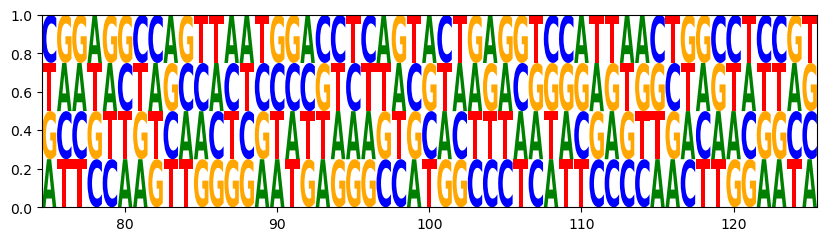

In [104]:
df = pd.DataFrame(PWM, columns=["A","C","G","T"])
logomaker.Logo(df.iloc[75:126,:]);

In [3]:
import nbdev.export as nb
nb.nb_export('08_gkmexplain_sp1.ipynb', './modules')